In [1]:
import re, sys
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs, RDLogger
from rdkit.Chem import rdChemReactions, AllChem, Draw, PandasTools
RDLogger.DisableLog('rdApp.*')
import warnings
warnings.filterwarnings('ignore')

#### Utils

In [2]:
# utils were placed here so the notebook can be run inde
def get_mol_H(df, smi_col, mol_id_col):
    mol_smis = [Chem.CanonSmiles(s) for s in df[smi_col]]
    mol_ids = list(df[mol_id_col])
    ps = Chem.SmilesParserParams()
    ps.removeHs=False 
    ps.allHsExplicit=True
    mols = [Chem.MolFromSmiles(s, ps) for s in mol_smis]
    mols_H = [Chem.RWMol(Chem.AddHs(m,explicitOnly=True)) for m in mols]
    return mols_H, mol_ids

def get_fragment_bonds(mol):
    """Identify the bonds used to fragment a molecule into BBs for a specific chemical series.

    Args:
        mol (rdkit object): a molecule as an rdkit object

    Returns:
        fragment_bonds_list (list): the list of bonds used to break the molecule into BBs.
        fragment_bonds_list_labeled (list): the list of bonds labelled
    """
    fragment_bonds = []
    fragment_bonds_labeled = []

    # Core definition: exit vectors are defined on the lactam FG (B) to get A and C
    substr = '[*]-!@[#6;R;x2]-@[#7;$([#7]@[#6;$([#6]=[O])])]-!@[*]'
    substr_match = list(mol.GetSubstructMatches(Chem.MolFromSmarts(substr)))

    if len(substr_match) > 0: # reject any molecule not having this substructure, thus OO chemical series
        fragment_bonds = [substr_match[0][:2],substr_match[0][-2:]] # bond 1 before core A-B, bond after core B-C
        fragment_bonds_labeled = [(12, 21),(23, 32)] # for naming 1 = A, 2 = B and so on. This is helpful to know which atom is involved in which bond. 
        #e.g. (12, 21) is the bond connecting A to B with 12 being on the A side and 21 on the B side.
        
    return fragment_bonds, fragment_bonds_labeled

def get_bbs_from_frag_bonds(mols_H, get_fragment_bonds, n_fragment_bonds):
    bb_smis = []
    uncut = 0
    
    for mol_id, mol in enumerate(mols_H):
        fragment_bonds, fragment_bonds_labeled = get_fragment_bonds(mol)
    	
        if '' in fragment_bonds or not fragment_bonds: # if rules does not work, returns empty bbs
            if n_fragment_bonds == 4:
                bb_smis.append(['', '', '',''])
            else:
                bb_smis.append(['', '', ''])
            uncut += 1
        else :
            all_bonds = mol.GetBonds()
            bidx = []
            labels = []
            for fragment_bond_id, fragment_bond in enumerate(fragment_bonds):
                for ib, bond in enumerate(all_bonds):
                    a = [bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]
                    if fragment_bond[0] == bond.GetBeginAtomIdx() and fragment_bond[1] == bond.GetEndAtomIdx():
                        bidx.append(bond.GetIdx())
                        labels.append(fragment_bonds_labeled[fragment_bond_id][::-1])
                        break
                    elif fragment_bond[1] == bond.GetBeginAtomIdx() and fragment_bond[0] == bond.GetEndAtomIdx():
                        bidx.append(bond.GetIdx())
                        labels.append(fragment_bonds_labeled[fragment_bond_id])
                        break
                        
            mol_frag = Chem.FragmentOnBonds(mol, tuple(bidx), dummyLabels=labels) # fragment the mol based on defined bonds
            mol_frag_smi = Chem.MolToSmiles(mol_frag)
            bbs_smi = [s for isx, s in enumerate(mol_frag_smi.split('.')) if "*" in s] #and s.count("["+str(isx+1))>0 ], a list of 3 BB smis
            bb_smis.append(bbs_smi) # appends all frag_smi together       
                
    return bb_smis, uncut

def get_mol_ids_with_bbs(bb_smis, mol_ids, mol_id_column):
    if len(bb_smis[0]) == 4:
        mol_ids_with_bbs = pd.DataFrame(bb_smis, columns=['A_smi', 'B_smi', 'C_smi', 'D_smi'])
    elif len(bb_smis[0]) == 3:
        mol_ids_with_bbs = pd.DataFrame(bb_smis, columns=['A_smi', 'B_smi', 'C_smi'])
    else:
        mol_ids_with_bbs = None
        
    mol_ids_with_bbs[mol_id_column] = mol_ids
    
    return mol_ids_with_bbs

def get_bb_ids_with_count(mol_ids_with_bbs):
    smi_cols = [c for c in mol_ids_with_bbs.columns if "_smi" in c] 
    
    for ic, c in enumerate(smi_cols):
        bb_smi = mol_ids_with_bbs[mol_ids_with_bbs[c]!=''][c].unique() # unique should not change the order of the df
        bb_ids = [c.replace("_smi","") + str(i+1) for i,s in enumerate(bb_smi)]
        counts = []
        for bb in bb_smi:
            counts.append(len(mol_ids_with_bbs[mol_ids_with_bbs[c] == bb][c]))
        if ic == 0:
            bb_ids_with_count = pd.DataFrame({'bb_id':bb_ids,'bb_smi':bb_smi,'count':counts})  
        else:
            bb_ids_with_count = bb_ids_with_count._append(pd.DataFrame({'bb_id':bb_ids, 'bb_smi':bb_smi, 'count':counts}))
            
    return bb_ids_with_count.reset_index()

def assign_bb_ids_to_mol(mol_ids_with_bbs, bb_ids_with_count):
    bb_ids_with_count = bb_ids_with_count[['bb_id', 'bb_smi']]
    smi_cols = [c for c in mol_ids_with_bbs.columns if "_smi" in c]
    
    for ic, c in enumerate(smi_cols):
        ismis = bb_ids_with_count[bb_ids_with_count['bb_id'].str.contains(c[0])] # same position    
        df_t = mol_ids_with_bbs.merge(bb_ids_with_count, how='left', left_on=mol_ids_with_bbs[c].str.replace("*",""), right_on=bb_ids_with_count['bb_smi'].str.replace("*","")).rename(columns={'bb_id':c[0]+'_id'})
        mol_ids_with_bbs = df_t.drop(columns=['key_0','bb_smi'])
    return mol_ids_with_bbs
    
def format_bbs_df(bbs_df, mols_bbs_df, main_ppties):
    bbs_df = bbs_df[['bb_smi', 'bb_id']]
    bbs_df['bb_tag'] = bbs_df['bb_id'].str[0].astype(str)
    
    for ppty in main_ppties:
        for index, row in bbs_df.iterrows():
            median, count, score = get_ppty_median_count_from_bb_id(mols_bbs_df, row['bb_id'], ppty)
            bbs_df.at[index, ppty+'_count'] = int(count)
            bbs_df.at[index, ppty+'_median'] = round(median, 2)
            bbs_df.at[index, ppty+'_score'] = round(score, 2)
        print(ppty)
        
    return bbs_df

def get_ppty_median_count_from_bb_id(df, bb_id, ppty):
    # currently handle 3 or 4 BBs
    try:
        filt = (df['A_id'] == bb_id) | (df['B_id'] == bb_id) | (df['C_id'] == bb_id) | (df['D_id'] == bb_id)
    except:
        filt = (df['A_id'] == bb_id) | (df['B_id'] == bb_id) | (df['C_id'] == bb_id)
    df = df[filt]
    median = df[ppty].median()
    count = df[ppty].count()
    cv = (df[ppty].std() / df[ppty].mean()) * 100
    if ppty in ['IP1_EC50', 'HLM', 'MDR1_efflux', 'logD'] and cv != None:
        score = median + cv
    elif cv != None:
        score = median - cv
    else:
        score = None

    return median, count, score

def rank_bbs_ppties(bbs_df, ppties_list):
    unfavorabel_gain_ppties = ['EC50_main', 'OX1_IP1_EC50', 'HLM']
    filt = bbs_df['bb_id'].str.contains('A')
    bb_a = bbs_df[filt]
    filt = bbs_df['bb_id'].str.contains('B')
    bb_b = bbs_df[filt]
    filt = bbs_df['bb_id'].str.contains('C')
    bb_c = bbs_df[filt]
    for ppty in ppties_list:
        if ppty in unfavorabel_gain_ppties:
            bb_a[ppty+'_rank'] = bb_a[ppty+'_median'].rank(method='min', ascending=True).fillna(0).astype(int)
            bb_b[ppty+'_rank'] = bb_b[ppty+'_median'].rank(method='min', ascending=True).fillna(0).astype(int)
            bb_c[ppty+'_rank'] = bb_c[ppty+'_median'].rank(method='min', ascending=True).fillna(0).astype(int)
        else:
            bb_a[ppty+'_rank'] = bb_a[ppty+'_median'].rank(method='min', ascending=False).fillna(0).astype(int)
            bb_b[ppty+'_rank'] = bb_b[ppty+'_median'].rank(method='min', ascending=False).fillna(0).astype(int)
            bb_c[ppty+'_rank'] = bb_c[ppty+'_median'].rank(method='min', ascending=False).fillna(0).astype(int)
    bbs_df = pd.concat([bb_a, bb_b, bb_c]) 
    return bbs_df

#### Data Processing: fragment the Chemical Series into its consituent BBs
##### Load dataset

In [3]:
mols_with_ppties = PandasTools.LoadSDF('DORA_Lactam_mols.sdf', smilesName='mol_smi', molColName='ROMol')

##### Show bonds used to fragment the chemical series into BBs

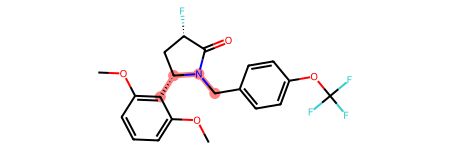

In [4]:
mol = Chem.MolFromSmiles('COc1cccc(OC)c1[C@@H]1C[C@H](F)C(=O)N1Cc1ccc(OC(F)(F)F)cc1') # a molecule from the chemical series
mol.GetSubstructMatches(Chem.MolFromSmarts('[*]-!@[#6;R;x2]-@[#7;$([#7]@[#6;$([#6]=[O])])]-!@[*]')) # the substr used to define C, thus A and B
mol

##### Assign BBs to molecules using the fragmentation rules above

In [5]:
mols_H, mol_ids = get_mol_H(mols_with_ppties, 'mol_smi', 'ID')
bb_smis, uncut = get_bbs_from_frag_bonds(mols_H, get_fragment_bonds, 3)
mol_ids_with_bbs = get_mol_ids_with_bbs(bb_smis, mol_ids, 'ID')
bb_ids_with_count = get_bb_ids_with_count(mol_ids_with_bbs)
mol_ids_with_bb_ids = assign_bb_ids_to_mol(mol_ids_with_bbs, bb_ids_with_count)
mols_with_bb_ids = pd.merge(mols_with_ppties, mol_ids_with_bb_ids, on='ID')

##### Write mols_bbs.json

In [6]:
mols_with_bb_ids = mols_with_bb_ids[['ID', 'mol_smi', 'EC50_main', 'A_id', 'B_id', 'C_id', 'OX1_IP1_EC50', 'HLM', 'CYP_testo',
       'ratio_hOX1R_hOX2R', 'mol_flag']]
mols_with_bb_ids.rename(columns={'ID':'mol_id'}, inplace=True)
mols_with_bb_ids['project'] = 'DORA'
mols_with_bb_ids['series'] = 'Lactam'
# fix B22/68 stereo: this is done to distinguish the enantio pure BB from the racemic for later analysis
mols_with_bb_ids.loc[(mols_with_bb_ids['B_id'] == 'B22') & (mols_with_bb_ids['mol_flag'] == 'this enantiomer R'), 'B_id'] = 'B68'
mols_with_bb_ids['bbs_id'] = mols_with_bb_ids[['A_id', 'B_id', 'C_id']].values.tolist()
mols_with_bb_ids['sub_series'] = ''
mols_with_bb_ids['EC50_main'] = mols_with_bb_ids['EC50_main'].astype(float)
mols_with_bb_ids['CYP_testo'] =  pd.to_numeric(mols_with_bb_ids['CYP_testo'], errors='coerce')
mols_with_bb_ids['OX1_IP1_EC50'] = mols_with_bb_ids['OX1_IP1_EC50'].astype(float)
mols_with_bb_ids['HLM'] =  pd.to_numeric(mols_with_bb_ids['HLM'], errors='coerce')
mols_with_bb_ids['ratio_hOX1R_hOX2R'] = mols_with_bb_ids['ratio_hOX1R_hOX2R'].astype(float)
mols_with_bb_ids.to_json('DORA_Lactam_mols_bbs.json', orient = 'records')

##### Write bbs.json

In [ ]:
# insert B68: this is done to distinguish the enantio pure BB from the racemic for later analysis
new_row = {'index': 323, 'bb_id': 'B68', 'bb_smi': '[21*][C@]1([H])C[C@@]([H])(O)C(=O)N1[23*]', 'count': 15}
bb_ids_with_count = pd.concat([bb_ids_with_count, pd.DataFrame([new_row])], ignore_index=True)
bb_ids_with_count.loc[(bb_ids_with_count['bb_id'] == 'B22'), 'count'] = 87

In [ ]:
# Extract the letter part (e.g., 'A', 'B', etc.) and numeric part separately
bb_ids_with_count['bb_letter'] = bb_ids_with_count['bb_id'].str.extract('([A-Z]+)')
bb_ids_with_count['bb_number'] = bb_ids_with_count['bb_id'].str.extract('(\d+)').astype(int)
bb_ids_with_count = bb_ids_with_count.sort_values(by=['bb_letter', 'bb_number'])
bb_ids_with_count = bb_ids_with_count.drop(columns=['bb_letter', 'bb_number'])

In [ ]:
mols_with_bb_ids['EC50_main'] = mols_with_bb_ids['EC50_main'].astype(float)
mols_with_bb_ids['CYP_testo'] =  pd.to_numeric(mols_with_bb_ids['CYP_testo'], errors='coerce')
mols_with_bb_ids['OX1_IP1_EC50'] = mols_with_bb_ids['OX1_IP1_EC50'].astype(float)
mols_with_bb_ids['HLM'] =  pd.to_numeric(mols_with_bb_ids['HLM'], errors='coerce')
mols_with_bb_ids['ratio_hOX1R_hOX2R'] = mols_with_bb_ids['ratio_hOX1R_hOX2R'].astype(float)
bbs_with_ppties = format_bbs_df(bb_ids_with_count, mols_with_bb_ids, ['EC50_main', 'CYP_testo', 'OX1_IP1_EC50', 'HLM', 'ratio_hOX1R_hOX2R'])

In [ ]:
bbs_with_ppties = rank_bbs_ppties(bbs_with_ppties, ['EC50_main', 'CYP_testo', 'OX1_IP1_EC50', 'HLM', 'ratio_hOX1R_hOX2R'])

In [ ]:
bbs_with_ppties['project'] = 'DORA'
bbs_with_ppties['series'] = 'Lactam'
bbs_with_ppties['count'] = bbs_with_ppties['EC50_main_count'].astype(int)

In [ ]:
bbs_with_ppties.to_json('../data/DORA_Lactam_bbs.json', orient = 'records')